Exercise 1: Newton-Raphson and Gauss-Newton

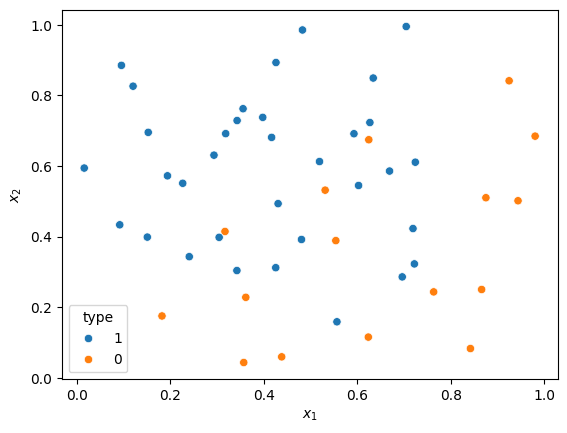

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)

# Simulate 50 binary observations with noisy linear decision boundary
n = 50
X = np.random.rand(n, 2)
X_model = np.c_[np.ones(n), X] 

# Generate the labels using the decision boundary with some noise
y = -1*((X_model @ np.array([0.3, -1, 1])) + np.random.normal(0, 0.3, n) < 0) + 1

# Create a DataFrame for plotting
df = pd.DataFrame(X, columns=['V1', 'V2'])
df['type'] = y.astype(str)

# Plot using seaborn
sns.scatterplot(x='V1', y='V2', hue='type', data=df)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()


#### Brier-loss: 
$R_{\text{emp}} = \sum_{i=1}^{n} \| y^{(i)} - \pi(x^{(i)}) \|_2^2$

#### Model:
$\pi : \mathbb{R}^2 \to [0, 1], \quad (x_1, x_2) \mapsto \frac{1}{1 + \exp\left( \begin{pmatrix} 1 , x_1 , x_2 \end{pmatrix}^\top \theta \right)}$

In [38]:
def model_function(x1,x2, theta):
    return 1 / (1 + np.exp(np.array([1, x1, x2]) @ theta)) 

def Remp(X, y, theta):
    total = 0
    for i in range(len(X)):
        total += brier_loss(X[i], y[i], theta)
    return total

def brier_loss(X, y, theta):
    pi = model_function(*X, theta)
    return (y - pi) ** 2

def grad_Remp(X,y,theta):
    total = np.zeros(len(theta))
    for i in range(len(X)):
        x = np.array([1,*X[i]]).transpose()
        f_i = x.T @ theta

        term1 = y[i] * np.exp(f_i)
        term2 = 1 / (np.exp(-f_i) + 1)

        total += (2*(term1 - term2) * x) / np.power((np.exp(f_i) + 1), 2)
    return total


def hessian_Remp(X,y,theta):
    total = np.zeros((len(theta),len(theta)))
    for i in range(len(X)):
        x = np.array([1,*X[i]]).transpose()
        f_i = x.T @ theta
        top = 2 * np.exp(f_i) * (y[i] * (-np.exp(2*f_i)+1)-1+2*np.exp(f_i))
        
        total += (top * np.outer(x, x)) / np.power((np.exp(f_i) + 1), 4)
    return total


Write an R script to find an optimal model via Newton-Raphson (do 30 iterations, $x_{[0]} = 0$)

In [39]:
theta = np.zeros(3)

# Testing start losses 
print(f"Loss:\n{Remp(X, y, theta)}")

grad = grad_Remp(X, y, theta)
print(f"\nGradient:\n{grad}")

hess = hessian_Remp(X, y, theta)
print(f"\nHessian_Remp:\n{hess}")

Loss:
12.5

Gradient:
[4.5        0.97324447 3.59290434]

Hessian_Remp:
[[6.25       3.03416592 3.23369508]
 [3.03416592 1.84669919 1.54726389]
 [3.23369508 1.54726389 2.04883453]]


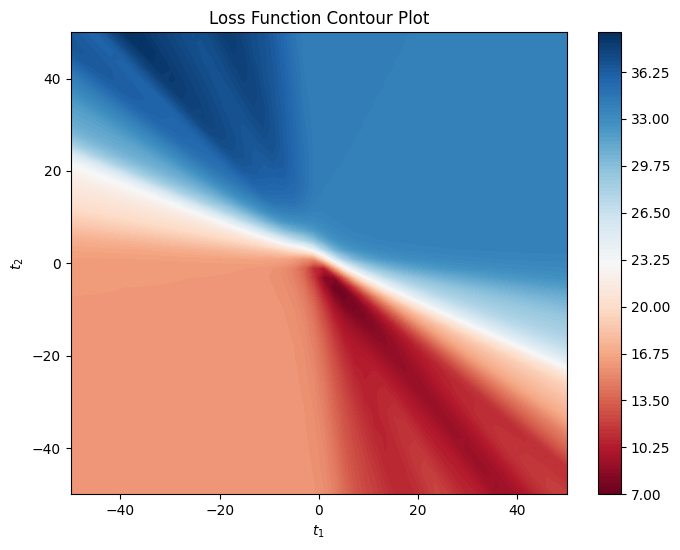

In [40]:
t1_vals = np.linspace(-50,50,50)
t2_vals = np.linspace(-50,50,50)
t1, t2 = np.meshgrid(t1_vals, t2_vals)

value = np.zeros_like(t1)

for i in range(t1.shape[0]):
    for j in range(t1.shape[1]):
        t = np.array([0, t1[i, j], t2[i, j]])
        value[i, j] = Remp(X,y,t)

plt.figure(figsize=(8, 6))
cp = plt.contourf(t1, t2, value, levels=150, cmap='RdBu')
plt.colorbar(cp)
plt.title("Loss Function Contour Plot")
plt.xlabel("$t_1$")

plt.ylabel("$t_2$")
plt.show()

In practice, we get $d^{[t]}$ by solving the linear system

$$
\nabla^2 f(x[t]) \, d[t] = -\nabla f(x[t])
$$

In [41]:
def d_t(X, y, theta):
    return np.linalg.solve(hessian_Remp(X, y, theta), -grad_Remp(X, y, theta))

d_t(X, y, theta)

array([-0.55368475,  3.04906325, -3.18237616])

In [42]:
losses = []
history = []
for i in range(30):
    losses.append(Remp(X, y, theta))
    history.append(theta.copy())
    theta += d_t(X, y, theta)
history = np.array(history)

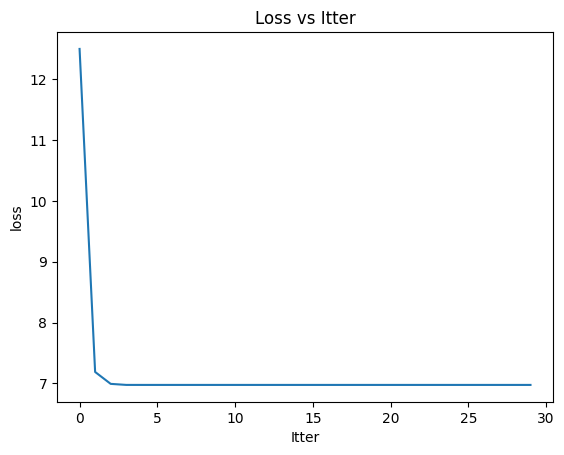

In [43]:
plt.plot(losses)
plt.title("Loss vs Itter")
plt.xlabel("Itter")
plt.ylabel("loss")
plt.show()

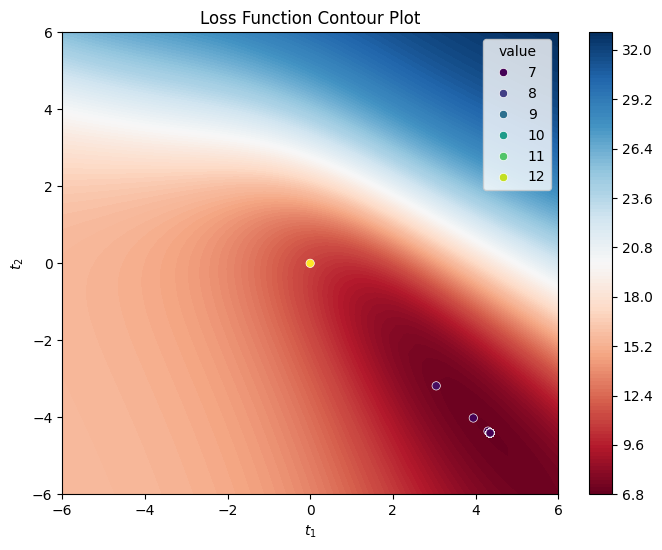

In [44]:
t1_vals = np.linspace(-6,6,50)
t2_vals = np.linspace(-6,6,50)
t1, t2 = np.meshgrid(t1_vals, t2_vals)

value = np.zeros_like(t1)

for i in range(t1.shape[0]):
    for j in range(t1.shape[1]):
        t = np.array([-0.84282475, t1[i, j], t2[i, j]])
        value[i, j] = Remp(X,y,t)

plt.figure(figsize=(8, 6))
cp = plt.contourf(t1, t2, value, levels=150, cmap='RdBu')
plt.colorbar(cp)
plt.title("Loss Function Contour Plot")
plt.xlabel("$t_1$")

plt.ylabel("$t_2$")
sns.scatterplot(x='X1', y='X2', hue='value',
                palette='viridis', data=pd.DataFrame({'X1': history[:, 1], 'X2': history[:, 2], 'value': losses}), marker='o')
plt.show()

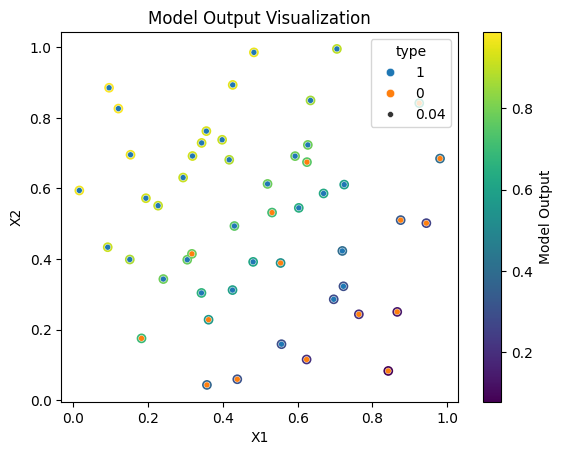

In [45]:
outputs = []

for i in range(len(X)):
    result = model_function(X[i][0], X[i][1], theta)
    outputs.append(result)
    
outputs = np.array(outputs)

# Plotting
plt.scatter(X[:, 0], X[:, 1], c=outputs, cmap='viridis')  # Color by model output
sns.scatterplot(x='V1', y='V2', hue='type', data=df, size=0.04)
plt.colorbar(label='Model Output')  # Show color scale
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Model Output Visualization')
plt.show()
